In [1]:

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)


# Synthetic PV Dataset Generation

This notebook generates a high-fidelity synthetic dataset for MPPT training.
It includes:

- Solar irradiance with partial shading
- Ambient and PV cell temperature
- PV parameters: Voc, Isc, Vmp, Imp, Pmp
- MPPT duty cycle for buck converter

The dataset can later be used for:

- Static ML model training (non-time-series)
- RNN/LSTM time-series MPPT model


In [2]:
# Simulation settings
num_samples = 50000          # Total number of data points
V_bus = 400.0                # DC bus voltage for duty cycle calculation
Isc_ref = 9.0                # Short-circuit current at STC (A)
Voc_ref = 37.0               # Open-circuit voltage at STC (V)
Vmp_ref = 32.0               # Voltage at MPP at STC (V)
Imp_ref = 5.7                # Current at MPP at STC (A)
G_ref = 1000.0               # Reference irradiance (W/m2)
T_ref = 25.0                 # Reference temperature (C)
NOCT = 45.0                  # Nominal operating cell temperature
Kv = -0.12                   # Voc temperature coefficient (V/C)


In [3]:
# Generate base daily irradiance curve (sine wave)
t = np.arange(num_samples)  # time index
hours = (t / 3600) % 24     # convert to hours in day
G_clear = 1000 * np.maximum(0, np.sin((np.pi/12)*(hours-6)))  # peak at noon

# Add cloud / noise fluctuations
G_noise = G_clear + np.random.normal(0, 30, size=num_samples)  # +/-30 W/m2
G_noise = np.clip(G_noise, 0, None)

# Ambient temperature profile (sinusoidal + noise)
T_amb = 25 + 5*np.sin((np.pi/12)*(hours-6)) + np.random.normal(0,1,num_samples)


In [4]:
# Initialize shade factor = 1.0 (no shade)
shade_factor = np.ones(num_samples)

# Generate random shading events
num_shade_events = 200
for _ in range(num_shade_events):
    start = np.random.randint(0, num_samples-300)
    duration = np.random.randint(10, 300)
    factor = np.random.uniform(0.2, 0.8)
    shade_factor[start:start+duration] *= factor

# Compute effective irradiance
G_effective = G_noise * shade_factor


In [5]:
T_cell = T_amb + (NOCT - 20)/800 * G_effective


In [6]:
# Short-circuit current
Isc = Isc_ref * (G_effective / G_ref)

# Open-circuit voltage
Voc = Voc_ref + Kv * (T_cell - T_ref)

# Simplified Vmp, Imp (linear scaling)
Vmp = Vmp_ref * (Voc / Voc_ref)
Imp = Imp_ref * (Isc / Isc_ref)

# Maximum power
Pmp = Vmp * Imp


In [7]:
duty_cycle = np.clip(Vmp / V_bus, 0.05, 0.95)



In [8]:
df = pd.DataFrame({
    'time': t,
    'G': G_noise,
    'T_amb': T_amb,
    'shade_factor': shade_factor,
    'G_effective': G_effective,
    'T_cell': T_cell,
    'Isc': Isc,
    'Voc': Voc,
    'Vmp': Vmp,
    'Imp': Imp,
    'Pmp': Pmp,
    'duty_cycle': duty_cycle
})

df.head()


,time,G,T_amb,shade_factor,G_effective,T_cell,Isc,Voc,Vmp,Imp,Pmp,duty_cycle
0,0,14.901425,20.098206,1.0,14.901425,20.563876,0.134113,37.532335,32.460398,0.084938,2.757125,0.081151
1,1,0.000000,19.935892,1.0,0.000000,19.935892,0.000000,37.607693,32.525572,0.000000,0.000000,0.081314
2,2,19.430656,20.951791,1.0,19.430656,21.558999,0.174876,37.412920,32.357120,0.110755,3.583704,0.080893
3,3,45.690896,21.532831,1.0,45.690896,22.960672,0.411218,37.244719,32.211649,0.260438,8.389141,0.080529
4,4,0.000000,20.686847,1.0,0.000000,20.686847,0.000000,37.517578,32.447635,0.000000,0.000000,0.081119


In [9]:
df.to_csv('pv_mppt_dataset.csv', index=False)
print("Dataset saved as pv_mppt_dataset.csv")


Dataset saved as pv_mppt_dataset.csv


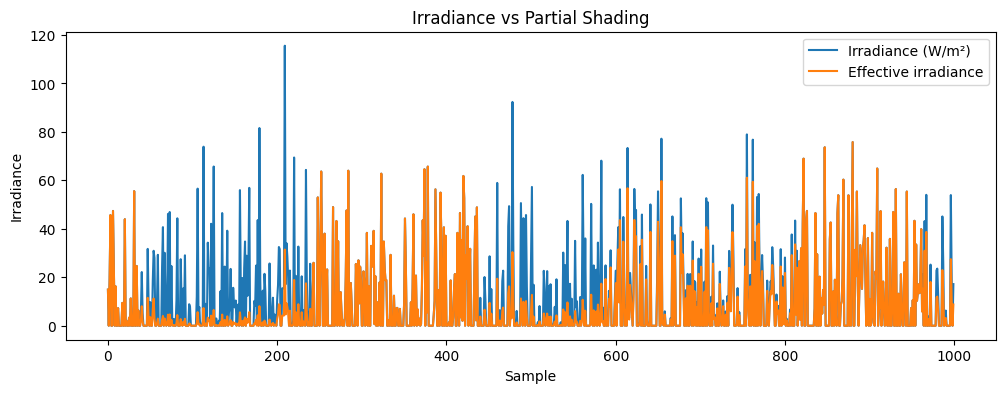

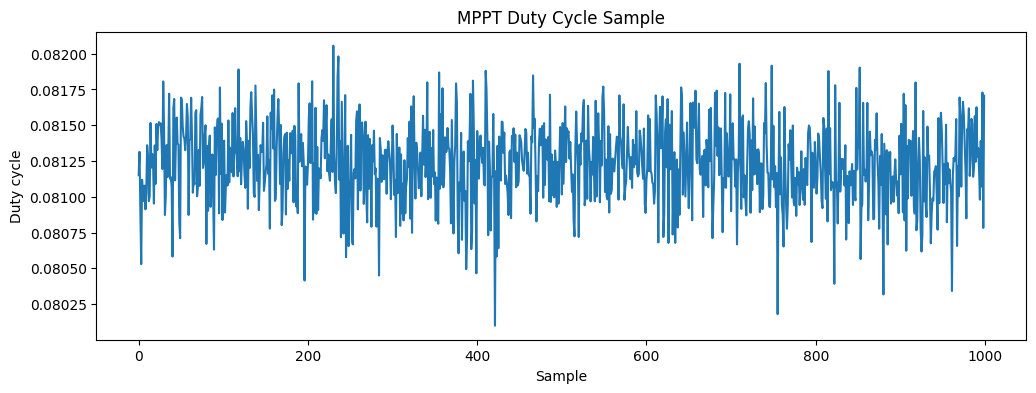

In [10]:
plt.figure(figsize=(12,4))
plt.plot(df['G'][:1000], label='Irradiance (W/m²)')
plt.plot(df['G_effective'][:1000], label='Effective irradiance')
plt.xlabel('Sample')
plt.ylabel('Irradiance')
plt.legend()
plt.title('Irradiance vs Partial Shading')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df['duty_cycle'][:1000], label='Duty cycle')
plt.xlabel('Sample')
plt.ylabel('Duty cycle')
plt.title('MPPT Duty Cycle Sample')
plt.show()
